In [29]:
import os  # 用於文件操作
import cv2  # 用於影像處理
import math  # 用於數學運算
import numpy as np  # 用於數值運算
import pandas as pd  # 用於數據處理
import joblib  # 用於保存和加載資料縮放器
import matplotlib.pyplot as plt  # 用於繪圖
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime  # 用於時間操作
from sklearn.preprocessing import MinMaxScaler  # 用於資料縮放
import matplotlib.font_manager as fm

import tensorflow as tf  # 用於構建模型
from tensorflow.keras import backend as K  # 用於自定義損失函數

jheng_hei_b_font = fm.FontProperties(fname=r'.\fonts\微軟正黑體_粗體.ttc')
jheng_hei_font = fm.FontProperties(fname=r'.\fonts\微軟正黑體_標準.ttc')

In [30]:
SPLIT_DATA_MODE = 'month'  # 數據分割模式 sequence or month
LATITUDE = 'Latitude'
LONGITUDE = 'Longitude'
WINDOW_SIZE = 2
STEP_SIZE = 1
CELL_DATASET_PATH = r'H:\cell_data_processed\cells'
SCALER_PATH = rf'config\{SPLIT_DATA_MODE}\lstm_multitask_scaler.gz'
MODEL_PATH = rf'weights\month\lstm_multitask\lstm_mt_diff2-1_e08v0.0005'

In [31]:
# ============= 均方根誤差 =============
def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# ============= 計算差分資料 =============
def data_diff_processing(data):
    data_filtered = data[['Latitude', 'Longitude']]
    data_diff = data_filtered.diff().dropna().reset_index(drop=True)
    return data_diff

# ============= 讀取模型 =============
def load_model(model_path: str, custom_objects: dict = None) -> tf.keras.models.Model:
    if custom_objects is None:
        return tf.keras.models.load_model(model_path)
    return tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# ============= 讀取scaler =============
def load_scaler(scaler_path: str) -> joblib.load:
    return joblib.load(scaler_path)

# ============= 讀取資料 =============
def read_data(start_date: str, end_date: str, scaler: MinMaxScaler) -> tuple:
    print(f'個案日期 {start_date} ~ {end_date}')
    def parse_datetime(date_str: str, is_end: bool = False) -> str:
        try:
            dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
            return dt.strftime('%Y%m%d%H%M%S')
        except ValueError:
            dt = datetime.strptime(date_str, '%Y-%m-%d')
            return dt.strftime('%Y%m%d') + ('235959' if is_end else '000000')

    start_date = parse_datetime(start_date, is_end=False)
    end_date = parse_datetime(end_date, is_end=True)

    print(f'開始日期: {start_date}, 結束日期: {end_date}')

    cell_files = sorted(os.listdir(CELL_DATASET_PATH))

    # 原始數值資料，每一個元素是一個DataFrame，每一個DataFrame是一個cell的數值序列
    dataset = []
    # 差分數值資料，每一個元素是一個DataFrame，每一個DataFrame是一個cell的差分數值序列
    diff_dataset = []
    # LSTM 輸入資料(差分數值資料)
    lstm_input_dataset = []

    for cell_file in cell_files:
        cell_file_path = os.path.join(CELL_DATASET_PATH, cell_file)
        date_part, time_part = cell_file.split(
            '_')[0].split('-')  # '20210101', '000000'
        dt = datetime.strptime(date_part + time_part, '%Y%m%d%H%M%S')
        target_date = dt.strftime('%Y%m%d%H%M%S')

        if not (start_date <= target_date <= end_date):
            continue

        # ============= 處理單一個數值序列資料 =============
        # 讀取CSV數據並計算差值
        cell_data = pd.read_csv(cell_file_path, encoding='utf-8',
                                dtype={'fileName': str, 'day': str, 'time': str})

        # 計算經緯度差分
        data_diff = cell_data[[LATITUDE, LONGITUDE]
                              ].diff().dropna().reset_index(drop=True)

        # 提取經度和緯度差值
        lat_diff = cell_data[LATITUDE].diff().dropna().reset_index(drop=True)
        lng_diff = cell_data[LONGITUDE].diff().dropna().reset_index(drop=True)

        combined_data = np.vstack([lat_diff.values, lng_diff.values]).T  # 經緯度差異合併

        # 使用scaler對資料進行縮放
        scaled_data_diff = scaler.transform(combined_data)

        dataset.append(cell_data)
        diff_dataset.append(data_diff)
        lstm_input_dataset.append(scaled_data_diff)

    return (dataset, diff_dataset, lstm_input_dataset)

In [32]:
# ============= 預測路徑 =============
def predict_path(model: tf.keras.models.Model, dataset_components: tuple) -> np.array:
    dataset, diff_dataset, lstm_input_dataset = dataset_components

    diff_pred_dict = {}  # 用經緯度差分預測結果
    diff_true_dict = {}  # 用經緯度差分真實結果

    for i, data in enumerate(dataset):

        diff_pred = []  # [(lat_diff, lng_diff), (lat_diff, lng_diff), ...]
        diff_true = []  # [(lat_diff, lng_diff), (lat_diff, lng_diff), ...]

        for j in range(0, len(lstm_input_dataset[i]) - WINDOW_SIZE, STEP_SIZE):
            # 準備 LSTM 和 ConvLSTM 輸入數據
            lstm_input = np.expand_dims(
                np.array(lstm_input_dataset[i][j: j+WINDOW_SIZE], dtype=np.float32), axis=0)
            
            input_data = lstm_input

            # 預測經緯度差分
            lat_pred, lng_pred = model.predict(input_data)

            # 獲取真實經緯度差分
            true_lat = diff_dataset[i][LATITUDE].values[j+WINDOW_SIZE]
            true_lng = diff_dataset[i][LONGITUDE].values[j+WINDOW_SIZE]

            diff_pred.append((lat_pred.item(), lng_pred.item()))
            diff_true.append((true_lat, true_lng))

        diff_pred_dict[i] = diff_pred
        diff_true_dict[i] = diff_true

    return dataset, diff_pred_dict, diff_true_dict

In [33]:
def plot_path(dataset: list, pred_dict: dict) -> None:
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())  # 經緯度座標系

    # =================== 統計所有經緯度的最大最小值 ===================
    all_lats = []
    all_lngs = []

    for i, data in enumerate(dataset):
        lats = np.array(data[LATITUDE])
        lngs = np.array(data[LONGITUDE])
        all_lats.extend(lats)
        all_lngs.extend(lngs)

        for pred in pred_dict[i]:
            pred_lat, pred_lng = pred
            all_lats.append(pred_lat)
            all_lngs.append(pred_lng)

    min_lat, max_lat = min(all_lats), max(all_lats)
    min_lng, max_lng = min(all_lngs), max(all_lngs)

    # =================== 繪圖開始 ===================
    ax.coastlines(resolution='10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # 設定經緯度邊界，加 buffer
    lat_buffer = (max_lat - min_lat) * 0.05
    lng_buffer = (max_lng - min_lng) * 0.05
    # ax.set_extent([min_lng - lng_buffer, max_lng + lng_buffer,
    #                min_lat - lat_buffer, max_lat + lat_buffer], crs=ccrs.PlateCarree())

    # '梅雨鋒面個案_2021-05-30'
    # ax.set_extent([119.8001659, 123.8208661, 23.81446730319214, 26.75911663296509], crs=ccrs.PlateCarree())
    # min_lat, max_lat = 23.45, 26.5
    # min_lng, max_lng = 119.8, 123.8
    # extent = [min_lng, max_lng, min_lat, max_lat]  # 台灣範圍
    # ax.set_extent(extent, crs=ccrs.PlateCarree())

    # '午後對流個案_2022-08-25'
    # min_lat, max_lat = 23.25, 25.75
    # min_lng, max_lng = 119.75, 122.5
    # extent = [min_lng, max_lng, min_lat, max_lat]  # 台灣範圍
    # print(f'設定經緯度範圍: {extent}')
    # ax.set_extent(extent, crs=ccrs.PlateCarree())

    # '烟花颱風個案_2021-07-22'
    min_lat, max_lat = 22.75, 27.45
    min_lng, max_lng = 120.15, 124.15
    extent = [min_lng, max_lng, min_lat, max_lat]  # 台灣範圍
    print(f'設定經緯度範圍: {extent}')
    ax.set_extent(extent, crs=ccrs.PlateCarree())


    # 設定 X、Y 軸刻度（每隔 0.5 度一格可調整）
    x_ticks = np.round(np.arange(min_lng, max_lng + 0.1, 0.5), 2)
    y_ticks = np.round(np.arange(min_lat, max_lat + 0.1, 0.5), 2)
    ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=8)

    # 可選：顯示經緯度刻度線
    ax.gridlines(draw_labels=False, linewidth=0.5,
                 color='gray', alpha=0.5, linestyle='--')

    # =================== 畫實際與預測軌跡 ===================
    for i, data in enumerate(dataset):
        latitudes = list(np.array(data[LATITUDE]))
        longitudes = list(np.array(data[LONGITUDE]))

        # 差分轉回原始資料 --------------------------------------------------------------
        pred_latitudes = []
        pred_longitudes = []
        # [(lat_diff, lng_diff), (lat_diff, lng_diff), ...]
        for j, diff_pred in enumerate(diff_pred_dict[i]):
            pred_lat = diff_pred[0] + latitudes[j + WINDOW_SIZE]
            pred_lng = diff_pred[1] + longitudes[j + WINDOW_SIZE]
            pred_latitudes.append(pred_lat)
            pred_longitudes.append(pred_lng)

        plt.plot(longitudes, latitudes, marker='o',
                 markersize=1.5, color='#1f77b4', linewidth=.5)
        plt.plot(pred_longitudes, pred_latitudes, marker='o',
                 markersize=1.5, color='#ff7f0e', linewidth=.5)

    plt.legend(['真實路徑', '預測路徑'], prop=jheng_hei_font, fontsize=8)
    # plt.title(f'LSTM 預測路徑', fontproperties=jheng_hei_b_font, fontsize=14)
    plt.xlabel('經度', fontproperties=jheng_hei_b_font, fontsize=12)
    plt.ylabel('緯度', fontproperties=jheng_hei_b_font, fontsize=12)
    plt.tight_layout()
    plt.show()

In [34]:
import math
from haversine import haversine

# ============= 計算誤差(公里) =============
def calculate_mae_distance(lat_mae: float, lon_mae: float, latitude: float = 25.071182):
    lat_km = lat_mae * 111
    lon_km = lon_mae * 111 * math.cos(math.radians(latitude))
    return math.sqrt(lat_km**2 + lon_km**2)

# ============= 評估主函式 =============
def evaluate(dataset: list, pred_dict: dict, true_dict: dict) -> None:
    # ===== 差分誤差（模型預測結果） =====
    all_lat_diffs = []
    all_lng_diffs = []

    for idx in true_dict.keys():
        true_values = np.array(true_dict[idx])  # [N, 2]
        pred_values = np.array(pred_dict[idx])  # [N, 2]

        true_lat = true_values[:, 0]
        true_lng = true_values[:, 1]
        pred_lat = pred_values[:, 0]
        pred_lng = pred_values[:, 1]

        all_lat_diffs.extend(true_lat - pred_lat)
        all_lng_diffs.extend(true_lng - pred_lng)

    # 攤平成整體誤差
    all_lat_diffs = np.array(all_lat_diffs)
    all_lng_diffs = np.array(all_lng_diffs)

    lat_rmse = np.sqrt(np.mean(all_lat_diffs**2))
    lng_rmse = np.sqrt(np.mean(all_lng_diffs**2))
    lat_mse = np.mean(all_lat_diffs**2)
    lng_mse = np.mean(all_lng_diffs**2)
    lat_mae = np.mean(np.abs(all_lat_diffs))
    lng_mae = np.mean(np.abs(all_lng_diffs))

    # 五分山雷達站的經緯度
    # center_lat = 25.071182
    # center_lon = 121.781205
    km_distance = calculate_mae_distance(lat_mae, lng_mae, 25.071182)

    # print("=== 經緯度差（difference）評估 ===")
    # print(f'Latitude MSE: {lat_mse:.5f}')
    # print(f'Longitude MSE: {lng_mse:.5f}')
    # print(f'Latitude RMSE: {lat_rmse:.5f}')
    # print(f'Longitude RMSE: {lng_rmse:.5f}')
    # print(f'Latitude MAE: {lat_mae:.5f}')
    # print(f'Longitude MAE: {lng_mae:.5f}')
    # print(f'Average distance error (via MAE): {km_distance:.3f} km\n')

    # ===== 實際位置誤差（預測差加回原始位置） =====
    lat_errors = []
    lng_errors = []
    distances = []

    for i, data in enumerate(dataset):
        latitudes = np.array(data[LATITUDE])
        longitudes = np.array(data[LONGITUDE])

        for j, diff_pred in enumerate(pred_dict[i]):
            pred_lat = diff_pred[0] + latitudes[j + WINDOW_SIZE]
            pred_lng = diff_pred[1] + longitudes[j + WINDOW_SIZE]
            real_lat = latitudes[j + (WINDOW_SIZE + 1)]
            real_lng = longitudes[j + (WINDOW_SIZE + 1)]

            error_lat = abs(real_lat - pred_lat)
            error_lng = abs(real_lng - pred_lng)
            lat_errors.append(real_lat - pred_lat)
            lng_errors.append(real_lng - pred_lng)

            distances.append(haversine((real_lat, real_lng), (pred_lat, pred_lng)))

    lat_errors = np.array(lat_errors)
    lng_errors = np.array(lng_errors)

    lat_mae_pos = np.mean(np.abs(lat_errors))
    lng_mae_pos = np.mean(np.abs(lng_errors))
    lat_mse_pos = np.mean(lat_errors**2)
    lng_mse_pos = np.mean(lng_errors**2)
    lat_rmse_pos = np.sqrt(lat_mse_pos)
    lng_rmse_pos = np.sqrt(lng_mse_pos)
    avg_distance = np.mean(distances)

    print("=== 經緯度位置（還原後）評估 ===")
    print(f'Latitude MSE: {lat_mse_pos:.6f}')
    print(f'Longitude MSE: {lng_mse_pos:.6f}')
    print(f'Latitude MAE: {lat_mae_pos:.6f} 度')
    print(f'Longitude MAE: {lng_mae_pos:.6f} 度')
    print(f'Latitude RMSE: {lat_rmse_pos:.6f}')
    print(f'Longitude RMSE: {lng_rmse_pos:.6f}')
    print(f'Average Haversine distance error: {avg_distance:.6f} km')

--------------模型讀取成功--------------
個案日期 2021-07-22 06:00:00 ~ 2021-07-22 12:00:00
開始日期: 20210722060000, 結束日期: 20210722120000
1/1 [==============================] - 0s 18ms/step
=== 經緯度位置（還原後）評估 ===
Latitude MSE: 0.000810
Longitude MSE: 0.000326
Latitude MAE: 0.026406 度
Longitude MAE: 0.015034 度
Latitude RMSE: 0.028456
Longitude RMSE: 0.018060
Average Haversine distance error: 3.496747 km
設定經緯度範圍: [120.15, 124.15, 22.75, 27.45]


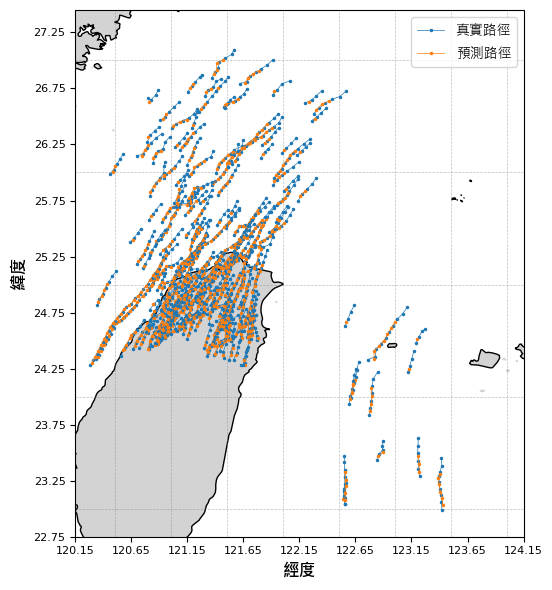

In [35]:
# 測試集資料範圍: 2022-07-01 ~ 2022-08-31 可按照需求調整
# start_date = '2022-10-04'
# end_date = '2022-10-04'
# start_date = '2022-12-06'
# end_date = '2022-12-06'
# 時序切割、月份切割共同資料集範圍
# ===================================
# # 2021-01-16  冬季降雨個案(不太好看)
# start_date = '2021-01-16 06:00:00'
# end_date = '2021-01-16 12:00:00'
# # 2021-05-30  梅雨鋒面個案
# start_date = '2021-05-30 04:00:00'
# end_date = '2021-05-30 10:00:00'
# # 2022-08-25  午後對流個案(很短很小)
# start_date = '2022-08-25 05:00:00'
# end_date = '2022-08-25 11:00:00'
# # 2021-07-22  烟花颱風個案(先不要)
start_date = '2021-07-22 06:00:00'
end_date = '2021-07-22 12:00:00'
# # 2022-09-04  軒嵐諾颱風
# start_date = '2022-09-04 11:00:00'
# end_date = '2022-09-04 17:00:00'
# ===================================

# 讀取模型
model = load_model(model_path=MODEL_PATH, custom_objects={'rmse': rmse})
# 列印模型結構
# print(model.summary())

print('--------------模型讀取成功--------------')

# 讀取資料縮放器
scaler = load_scaler(scaler_path=SCALER_PATH)

# 讀取資料(原始數值資料，差分數值資料，LSTM輸入數據，ConvLSTM輸入數據)
dataset_components = read_data(
    start_date=start_date,  
    end_date=end_date,  
    scaler=scaler
)

# 預測差分路徑
dataset, diff_pred_dict, diff_true_dict = predict_path(
    model=model, dataset_components=dataset_components)

# 評估模型
evaluate(dataset, diff_pred_dict, diff_true_dict)

# 繪製預測路徑與真實路徑
plot_path(dataset, diff_pred_dict)